In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.metrics import r2_score, mean_absolute_error
from gpytorch.mlls import ExactMarginalLogLikelihood
import gpytorch
import altair as alt
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import os

UTILITY

In [2]:
def plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration, label="target_value"):
    x = np.arange(len(candidates))  # Struktur-Index
    names = candidates["structure_name"].values

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    plt.subplots_adjust(hspace=0.3)

    axs[0].plot(x, mean_np, color="C0", label="Predicted Mean")
    axs[0].fill_between(x, mean_np - std_np, mean_np + std_np, color="C0", alpha=0.3, label="Uncertainty (±1σ)")
    axs[0].set_ylabel("Predicted Mean")
    axs[0].set_title(f"Iteration {iteration}: GP Prediction (mean ± std)")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    axs[1].plot(x, ei_np, color="C1")
    axs[1].set_ylabel("Expected Improvement")
    axs[1].set_title("Expected Improvement over Candidates")
    axs[1].grid(alpha=0.3)

    axs[2].plot(x, pi_np, color="C2")
    axs[2].set_ylabel("Probability of Improvement")
    axs[2].set_xlabel("Candidate Structure Index")
    axs[2].set_title("Probability of Improvement")
    axs[2].grid(alpha=0.3)

    # Optional: Struktur-Namen als xticks (nur alle paar, sonst zu viele)
    if len(names) <= 30:
        axs[2].set_xticks(x)
        axs[2].set_xticklabels(names, rotation=90)
    else:
        step = max(1, len(names)//30)
        axs[2].set_xticks(x[::step])
        axs[2].set_xticklabels(names[::step], rotation=90)

    plt.tight_layout()
    plt.show()


In [3]:
def is_bin_column(col) -> bool:
    """
    True für:
      - 'bin_0', 'bin_1', ... (beliebige nichtnegative Integer)
      - auch für numerische Spaltennamen wie 0, 1, '0', '1' (optional nützlich)
    """
    # numerische Spaltennamen zulassen (z. B. 0, 1, 2)
    if isinstance(col, (int, np.integer)):
        return True

    s = str(col)
    if s.isdigit():                 # '0', '1', ...
        return True
    if re.fullmatch(r"bin_\d+", s): # 'bin_0', 'bin_1', ...
        return True
    return False

MODELL GP

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp(xt_train, yt_train, training_iterations=100):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(xt_train, yt_train, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    losses = []

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(xt_train)
        loss = -mll(output, yt_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return model.eval(), likelihood.eval(), losses

DATEN EINLESEN & FILTERN

In [5]:
dft_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/dft_data_temp_pressure_swingswingswing5.csv")
dft_data["density_bulk"] = (
    dft_data["density_bulk"]
    .astype(str)                            # sicherstellen, dass alles string ist
    .str.strip()                             # Leerzeichen weg
    .str.replace('[', '', regex=False)       # "[" entfernen
    .str.replace(']', '', regex=False)       # "]" entfernen
)
dft_data["density_bulk"] = pd.to_numeric(dft_data["density_bulk"], errors="coerce")
expV_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_hist_no_pressure_no_chem_10b_swing.csv")
data = pd.merge(dft_data, expV_data, 'inner', on=["structure_name", "temperature_kelvin"])
feature_columns = [col for col in data.columns if is_bin_column(col)]
data = data[data.beladung_mol_per_kg > 0]
data = data[(data.temperature_kelvin == 298) & (data.pressure_bar == 5)]

data.head()

,structure_name,pressure_bar,temperature_kelvin,volume_kubAng,grid.dv,density_Atmos_per_kubAng,density_bulk,fraction_of_used_points,beladung_mol_per_kg,beladung_atoms,...,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,x_min,x_max
0,EON,5.0,298.0,3563.018109,0.013592,554.957698,0.000123,0.105804,2.092336,7.542894,...,2112,13848,3392,2136,1872,1528,1160,235448,-15.0,10.1
5,OKO,5.0,298.0,3884.589614,0.014819,614.753188,0.000123,0.127441,2.229677,9.109741,...,2472,17816,4392,2616,2024,1536,1248,230040,-15.0,10.1
10,MWW,5.0,298.0,4518.749756,0.017238,689.570508,0.000123,0.153900,2.747700,11.886584,...,5548,10948,13756,3108,2164,1672,1832,223116,-15.0,10.1
15,SFS,5.0,298.0,3367.496936,0.012846,687.762635,0.000123,0.141068,2.625806,8.834986,...,2572,17540,7204,3016,2188,1744,1612,226260,-15.0,10.1
20,DDR,5.0,298.0,6715.860313,0.025619,62.801051,0.000123,0.087776,0.215949,1.608898,...,7900,5619,2313,1736,1529,1241,1062,240043,-15.0,10.1


FEATURES/LABEL CUSTOM

In [6]:
#data["beladung_pro_vol"] = data["beladung_atoms"] / data["volume_kubAng"]

data["beladung_pro_vol"] = (
    data["beladung_atoms"]
    .div(data["density_bulk"], axis=0)
    .div(data["volume_kubAng"], axis=0)
)

data[feature_columns] = (
    data[feature_columns]
    .multiply(data["grid.dv"], axis=0)
    .div(data["volume_kubAng"], axis=0)
)


NORMALIZE

In [7]:
normalize_feature = True
normalize_labels = True

FOLD - TRAINING - PREDICTION

In [8]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

label = "beladung_pro_vol"
X = data[feature_columns].values 
y = data[label].values 

ids = data.index.values

split_info = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    x_train = torch.tensor(X[train_idx], dtype=torch.float64)
    y_train = torch.tensor(y[train_idx], dtype=torch.float64)
    x_test = torch.tensor(X[test_idx], dtype=torch.float64)
    y_test = torch.tensor(y[test_idx], dtype=torch.float64)

    train_ids = ids[train_idx]
    test_ids = ids[test_idx]

    test_df = data.iloc[test_idx].copy()
    test_df["fold"] = fold

    if normalize_feature:
        feature_transformer = MinMaxScaler()
        feature_transformer.fit(x_train)
        xt_train = torch.tensor(feature_transformer.transform(x_train), dtype=torch.float64)
        xt_test = torch.tensor(feature_transformer.transform(x_test), dtype=torch.float64) #*2
    else:
        xt_train = x_train
        xt_test = x_test

    # Label-Normalisierung
    if normalize_labels:
        label_transformer = MinMaxScaler()  # oder StandardScaler()
        label_transformer.fit(y_train.unsqueeze(1))
        yt_train = torch.tensor(label_transformer.transform(y_train.unsqueeze(1)).flatten(), dtype=torch.float64)
        yt_test = torch.tensor(label_transformer.transform(y_test.unsqueeze(1)).flatten(), dtype=torch.float64)
    else:
        yt_train = y_train
        yt_test = y_test

    # Training
    model, likelihood, losses = train_gp(xt_train, yt_train, training_iterations=200)

    # Prediction
    with torch.no_grad():
        prediction = model(xt_test)
        inverse_transformed_prediction = label_transformer.inverse_transform(
            prediction.mean.unsqueeze(1)
        ).squeeze()
        inverse_transformed_prediction = np.where(
            inverse_transformed_prediction > 0, inverse_transformed_prediction, 0
        )

    # Ergebnisse
    test_df[f"{label}_pred"] = inverse_transformed_prediction
    test_df["abs_rel_deviation"] = np.abs(
        (test_df[label] - test_df[f"{label}_pred"]) / test_df[label] * 100
    )

    split_info.append(test_df)

results = pd.concat(split_info, ignore_index=True)
r2 = r2_score(results[label], results[f"{label}_pred"])
mae = mean_absolute_error(results[label], results[f"{label}_pred"])
median_ape = results["abs_rel_deviation"].median()

results["R2"] = r2
results["MAE"] = mae
results["Median_APE_percent"] = median_ape
results

,structure_name,pressure_bar,temperature_kelvin,volume_kubAng,grid.dv,density_Atmos_per_kubAng,density_bulk,fraction_of_used_points,beladung_mol_per_kg,beladung_atoms,...,bin_9,x_min,x_max,beladung_pro_vol,fold,beladung_pro_vol_pred,abs_rel_deviation,R2,MAE,Median_APE_percent
0,OFF,5.0,298.0,1117.957819,0.004265,605.564421,0.000123,0.130646,2.254505,2.582533,...,0.874016,-15.0,10.1,18.829841,1,22.171070,17.744324,0.467008,3.605402,14.091386
1,PWO,5.0,298.0,1165.326305,0.004445,895.017840,0.000123,0.100128,3.310961,3.978683,...,0.905258,-15.0,10.1,27.830307,1,25.430545,8.622837,0.467008,3.605402,14.091386
2,CDO,5.0,298.0,1994.011066,0.007607,511.963182,0.000123,0.059753,1.800399,3.894273,...,0.944458,-15.0,10.1,15.919339,1,19.045056,19.634713,0.467008,3.605402,14.091386
3,STF,5.0,298.0,1896.240805,0.007234,721.701155,0.000123,0.135651,2.715225,5.220486,...,0.868652,-15.0,10.1,22.441078,1,19.288398,14.048701,0.467008,3.605402,14.091386
4,ZJN,5.0,298.0,3505.954803,0.013374,582.484137,0.000123,0.080536,2.160947,7.790234,...,0.922928,-15.0,10.1,18.112167,1,15.046193,16.927701,0.467008,3.605402,14.091386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,SSY,5.0,298.0,1659.354779,0.006330,452.522632,0.000123,0.118164,1.702654,2.864439,...,0.886017,-15.0,10.1,14.071054,10,15.279878,8.590863,0.467008,3.605402,14.091386
241,GME,5.0,298.0,1594.523637,0.006083,683.596964,0.000123,0.148911,2.883531,4.158064,...,0.856750,-15.0,10.1,21.256240,10,21.920891,3.126854,0.467008,3.605402,14.091386
242,AEI,5.0,298.0,3189.362594,0.012166,747.726676,0.000123,0.150024,3.154354,9.097181,...,0.856567,-15.0,10.1,23.250333,10,21.479229,7.617546,0.467008,3.605402,14.091386
243,GON,5.0,298.0,1691.906700,0.006454,422.568771,0.000123,0.070953,1.418498,2.727306,...,0.931183,-15.0,10.1,13.139647,10,13.468971,2.506337,0.467008,3.605402,14.091386


ALLE DATEN

In [9]:
print(f"R²                        : {r2_score(results[label], results[f'{label}_pred']):.4f}")
print(f"MAE                       : {mean_absolute_error(results[label], results[f'{label}_pred']):.4f}")
print(f"Median APE                : {results['abs_rel_deviation'].median():.2f}%")
print(f"Mean APE                  : {results['abs_rel_deviation'].mean():.2f}%")
print(f"Final Loss                : {losses[-1]:.4f}")

count = (results['abs_rel_deviation'] > 20).sum()
print(f"Abs rel dev > 20%         : {count} out of {len(results)}")
print(f"Max abs rel dev           : {results['abs_rel_deviation'].max():.2f}%")


R²                        : 0.4670
MAE                       : 3.6054
Median APE                : 14.09%
Mean APE                  : 44265.89%
Final Loss                : -0.7439
Abs rel dev > 20%         : 85 out of 245
Max abs rel dev           : 5230505.56%


EINZELNE FOLDS

In [10]:
for fold, group in results.groupby("fold"):
    print(f"\nFold {fold}")
    print(f"R²           : {r2_score(group[label], group[f'{label}_pred']):.4f}")
    print(f"Median APE   : {group['abs_rel_deviation'].median():.2f}%")
    print(f"Mean APE     : {group['abs_rel_deviation'].mean():.2f}%")
    print(f"Max ARD      : {group['abs_rel_deviation'].max():.2f}%")
    print(f"Final Loss   : {losses[-1]:.4f}")



Fold 1
R²           : 0.2961
Median APE   : 17.74%
Mean APE     : 28.18%
Max ARD      : 168.22%
Final Loss   : -0.7439

Fold 2
R²           : 0.7344
Median APE   : 10.95%
Mean APE     : 516.01%
Max ARD      : 12357.47%
Final Loss   : -0.7439

Fold 3
R²           : 0.4051
Median APE   : 22.23%
Mean APE     : 25.64%
Max ARD      : 87.74%
Final Loss   : -0.7439

Fold 4
R²           : 0.5348
Median APE   : 14.09%
Mean APE     : 47.18%
Max ARD      : 722.46%
Final Loss   : -0.7439

Fold 5
R²           : 0.2942
Median APE   : 12.41%
Mean APE     : 26635.57%
Max ARD      : 665467.63%
Final Loss   : -0.7439

Fold 6
R²           : 0.3550
Median APE   : 15.58%
Mean APE     : 88.89%
Max ARD      : 770.34%
Final Loss   : -0.7439

Fold 7
R²           : 0.4674
Median APE   : 17.60%
Mean APE     : 23.59%
Max ARD      : 100.00%
Final Loss   : -0.7439

Fold 8
R²           : 0.2991
Median APE   : 9.87%
Mean APE     : 26.29%
Max ARD      : 338.13%
Final Loss   : -0.7439

Fold 9
R²           : 0.6282
Med

PARITY PLOT - ALT

In [11]:
alt.Chart(results).mark_circle(size=60).encode(
    x=label,
    y=f"{label}_pred",
    color="fold:N",
    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]
).interactive()

alt.Chart(...)

In [12]:
"""
alt.Chart(results[results["fold"] == 1]).mark_circle(size=60).encode(
    x=label,
    y=f"{label}_pred",
    color="fold:N",
    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]
).interactive()
"""




'\nalt.Chart(results[results["fold"] == 1]).mark_circle(size=60).encode(\n    x=label,\n    y=f"{label}_pred",\n    color="fold:N",\n    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]\n).interactive()\n'

In [13]:
import numpy as np
import matplotlib.pyplot as plt



DATA ANALYSIS

In [14]:
high_dev_names = results.loc[results["abs_rel_deviation"] > 20, "structure_name"].tolist()
filtered_results = results[results["structure_name"].isin(high_dev_names)]
filtered_results

filter_res = results.sort_values(by="beladung_mol_per_kg", ascending=False)

filter_res.head()

,structure_name,pressure_bar,temperature_kelvin,volume_kubAng,grid.dv,density_Atmos_per_kubAng,density_bulk,fraction_of_used_points,beladung_mol_per_kg,beladung_atoms,...,bin_9,x_min,x_max,beladung_pro_vol,fold,beladung_pro_vol_pred,abs_rel_deviation,R2,MAE,Median_APE_percent
73,SBN,5.0,298.0,619.370118,0.002363,1631.751473,0.000123,0.066422,6.416661,3.855355,...,0.939255,-15.0,10.1,50.738815,3,25.507167,49.728494,0.467008,3.605402,14.091386
104,AFY,5.0,298.0,1132.678632,0.004321,1211.488926,0.000123,0.192543,5.445165,5.234633,...,0.814316,-15.0,10.1,37.670879,5,20.448669,45.717568,0.467008,3.605402,14.091386
119,ACO,5.0,298.0,971.769893,0.003707,1392.650241,0.000123,0.059875,5.370199,5.162566,...,0.945251,-15.0,10.1,43.304035,5,17.642587,59.258792,0.467008,3.605402,14.091386
203,RHO,5.0,298.0,3320.619714,0.012667,1001.115435,0.000123,0.183594,4.397106,12.681288,...,0.823364,-15.0,10.1,31.129380,9,20.779950,33.246502,0.467008,3.605402,14.091386
162,DFT,5.0,298.0,451.651904,0.001723,1127.695372,0.000123,0.044617,4.042132,1.942924,...,0.959106,-15.0,10.1,35.065344,7,19.740103,43.704809,0.467008,3.605402,14.091386


BAYESIAN OPTIMIZATION

In [15]:
from torch.distributions import Normal

def af_log_expIm(mean, var, best_f, xi=0.01):
    """Logarithmic Expected Improvement acquisition function."""

    std = torch.sqrt(var)
    std_safe = torch.clamp(std, min=1e-9)  # Avoid division by zero
    z = (mean - best_f - xi) / std_safe
    normal = Normal(torch.zeros_like(z), torch.ones_like(z))
    cdf = normal.cdf(z)
    pdf = torch.exp(normal.log_prob(z))

    ei = std * (z * cdf + pdf)

    ei_safe = torch.clamp(ei, min=1e-9)  # Avoid log(0)
    log_ei = torch.log(ei_safe)
    return log_ei
    


Initial training points:
  Index 105, Structure LIT, beladung_pro_vol: 0.0000
Iteration: 0, Current Best: 4.46e-05
Iteration: 1, Current Best: 9.86e+00
Iteration: 2, Current Best: 9.86e+00
Iteration: 3, Current Best: 9.86e+00
Iteration: 4, Current Best: 9.88e+00
Iteration: 5, Current Best: 1.14e+01
Iteration: 6, Current Best: 2.07e+01
Iteration: 7, Current Best: 2.07e+01
Iteration: 8, Current Best: 3.16e+01
Iteration: 9, Current Best: 3.16e+01
Iteration: 10, Current Best: 3.16e+01
Iteration: 11, Current Best: 3.16e+01
Iteration: 12, Current Best: 3.16e+01
Iteration: 13, Current Best: 3.16e+01
Iteration: 14, Current Best: 3.16e+01
Iteration: 15, Current Best: 3.16e+01
Iteration: 16, Current Best: 3.16e+01
Iteration: 17, Current Best: 3.21e+01
Iteration: 18, Current Best: 3.21e+01
Iteration: 19, Current Best: 3.21e+01
Iteration: 20, Current Best: 3.21e+01
Iteration: 21, Current Best: 3.21e+01
Iteration: 22, Current Best: 3.21e+01
Iteration: 23, Current Best: 3.21e+01
Iteration: 24, Curre

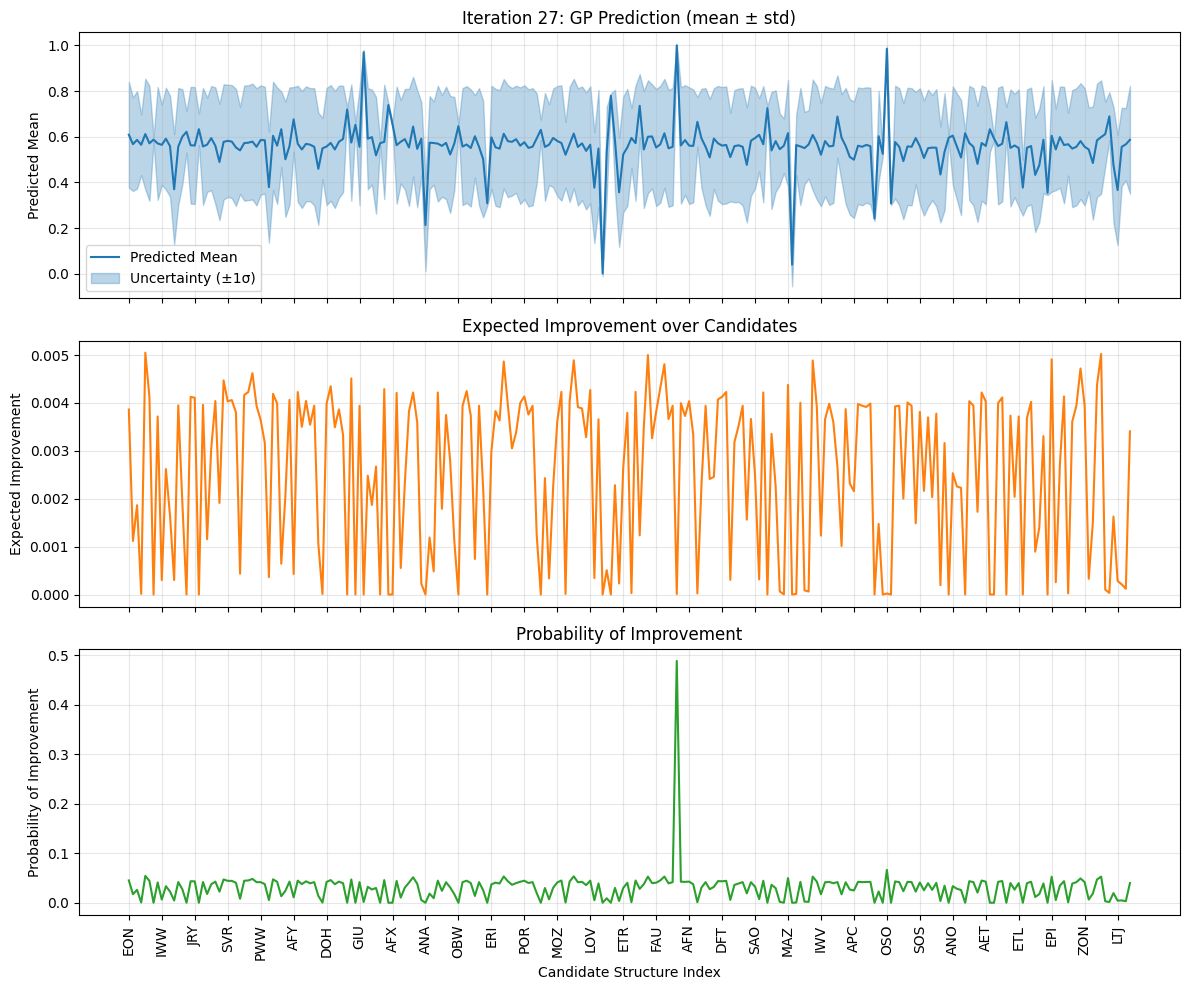

In [16]:
candidates = data.copy() # zunächst gefilteret, später alle Daten

patience = 10

n_initial = 1 # Anzahl der initialen Trainingspunkte
initial_indices = candidates.nsmallest(n_initial, label).index # hier geht auch random

print(f"Initial training points:")
for idx in initial_indices:
    print(f"  Index {idx}, Structure {candidates.loc[idx, 'structure_name']}, {label}: {candidates.loc[idx, label]:.4f}")

# Transfer from candidates to selection
selected = candidates.loc[initial_indices]
candidates = candidates.drop(initial_indices)
best = [selected[label].max()]

for i in range(100):
    if len(best) >= patience:
        if len(np.unique(best[-patience:])) == 1:
            print(f"Early stopping at iteration {i} due to no improvement in the last {patience} iterations.")
            break
    
    feature_transoformer = MinMaxScaler()
    label_transformer = MinMaxScaler()

    train_x = torch.tensor(feature_transoformer.fit_transform(selected[feature_columns].values))
    train_y = torch.tensor(label_transformer.fit_transform(selected[[label]].values)).flatten()

    test_x = torch.tensor(feature_transoformer.transform(candidates[feature_columns].values))

    model, likelihood, _ = train_gp(train_x, train_y, 250)
    with torch.no_grad():
        prediction = model(test_x)
        mean, var = prediction.mean, prediction.variance
    
    best_f = train_y.max()

    log_ei = af_log_expIm(mean, var, best_f, 0.01 * best_f)

    # Select the candidate with the highest acquisition value
    index = torch.argmax(log_ei).item()
    best.append(selected[label].max())
    print(f"Iteration: {i}, Current Best: {selected[label].max():.2e}")
    selected = pd.concat([selected, candidates.iloc[[index]]])
    canidates = candidates.drop(candidates.index[index])

print(f"Best Value after {len(best)} iterations: {best[-1]}")

mean_np = mean.detach().cpu().numpy().flatten()
var_np = var.detach().cpu().numpy().flatten()
std_np = np.sqrt(var_np)
ei_np = torch.exp(log_ei).detach().cpu().numpy().flatten()

# --- Probability of Improvement ---
best_f = train_y.max().item()
z = (mean_np - best_f) / std_np
pi_np = norm.cdf(z)


# --- Plot am Ende ---
plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration=i, label=label)
    

Text(0.5, 0, 'Iterations')

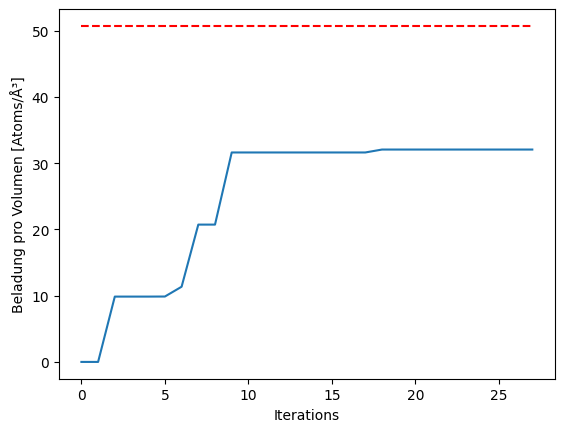

In [17]:
plt.plot(best)
plt.hlines(data[label].max(), 0, len(best)-1, colors='r', linestyles='dashed')
plt.ylabel("Beladung pro Volumen [Atoms/Å³]")
plt.xlabel("Iterations")